In [12]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
# !python3 -m spacy download en
from spacy.lang.es import Spanish
# !python3 -m spacy download es_core_news_md


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_sp=set(stopwords.words('spanish'))
stop_words_en=set(stopwords.words('english'))
stop_words=stop_words_sp | stop_words_en


import re

from langdetect import detect

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhatch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
url_base = "https://www.gob.mx/presidencia/es/archivo/articulos?idiom=es&order=DESC&page="

In [14]:
def obtiene_links(page):
    response = requests.get(url_base + str(page))
    sopa = BeautifulSoup(response.text)

    div_prensa = sopa.find(id='prensa')
    anchors = []
    if div_prensa is not None:
        anchors = div_prensa.find_all("a")
    else:
        # Esto hace que el scraping funcione aunque la página regrese JavaScript
        lineas = [linea.strip() for linea in response.text.split("\n") if "prensa" in linea]
        lineas_limpias = [linea[21:-2].replace('\\\"',"\"").replace('\/',"/").replace('\\n',"") for linea in lineas]
        for html_bonito in lineas_limpias:
            sopita = BeautifulSoup(html_bonito)
            anclas = sopita.find_all("a")
            anchors.extend(anclas)

    hrefs = ["https://www.gob.mx" + a["href"] for a in anchors]
    return hrefs

In [15]:
links = []
for pg in range(106):
    links.extend(obtiene_links(pg))

In [29]:
pres = []
salud = []
links_1 = pd.Series(links)
for link in links_1:
    if 'coronavirus' in link:
        salud.append(link)
    else:
        pres.append(link)

In [34]:
def obtiene_informacion(url):
    respuesta_articulo = requests.get(url)
    sopa_articulo = BeautifulSoup(respuesta_articulo.text)
    contenido = sopa_articulo.find_all("div", {"class":"pull-left"})[:-1]
    titulo = contenido[0].text
    parrafos = [parrafo.text for parrafo in contenido[1].find_all("p")]
    return parrafos

In [35]:
texto = []
for i in range(0,len(pres)):
    texto.extend(obtiene_informacion(pres[i]))

In [46]:
txt = pd.Series(texto,name = 'Texto')
text = txt.to_frame()
text.dropna(inplace = True)

In [47]:
def tokenizer(txt):  # texto    
    
    if detect(txt)=='en':    # si el texto esta en ingles...
        nlp=spacy.load('en')
        parser=English()
        
    elif detect(txt)=='es':   # si el texto esta en castellano...
        nlp=spacy.load('es_core_news_md')
        parser=Spanish()
        
    else:
        return 'No es castellano ni ingles.'
    
    tokens=parser(txt)
    
    filtered_tokens=[]
    
    for word in tokens:
        lemma=word.lemma_.lower().strip()
        if lemma not in STOP_WORDS and re.search('^[a-zA-Z]+$', lemma):
            filtered_tokens.append(lemma)
    
    return ' '.join(filtered_tokens)

In [51]:
def wordcloud(df,col): # dataframe, columna
    
    wordcloud=WordCloud(width=1600, height=400, stopwords=stop_words).generate(' '.join([e for e in df[col]]))

    plt.figure(figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig('./wordcloud.png', facecolor='k', bbox_inches='tight')
    plt.show()

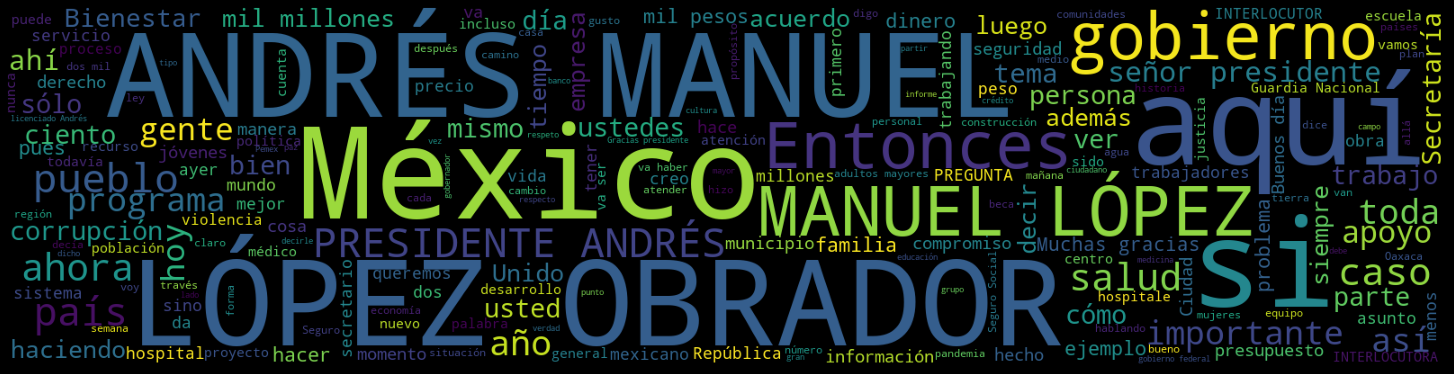

In [52]:
wordcloud(text, 'Texto')